## 순환 신경망(RNN)

In [5]:
import numpy as np

from Batch_Normalization_lab import batch_size


class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.matmul(h_prev, Wh) + np.matmul(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.matmul(h_prev.T, dt)
        dh_prev = np.matmul(dt, Wh.T)
        dWx = np.matmul(x.T, dt)
        dx = np.matmul(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs


In [11]:
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        embed_W = (rn(V, D) / 100).astype('f')
        runn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        runnWh = (rn(H, H) / np.sqrt(H)).astype('f')
        runn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(runn_Wx, runnWh, runn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()


말뭉치 크기: 1000, 어휘 수: 418
| epoch 1 | ppl 396.22
| epoch 2 | ppl 275.26
| epoch 3 | ppl 229.84
| epoch 4 | ppl 219.92
| epoch 5 | ppl 208.60
| epoch 6 | ppl 202.92
| epoch 7 | ppl 199.31
| epoch 8 | ppl 196.83
| epoch 9 | ppl 191.45
| epoch 10 | ppl 193.38
| epoch 11 | ppl 188.33
| epoch 12 | ppl 191.73
| epoch 13 | ppl 189.38
| epoch 14 | ppl 189.62
| epoch 15 | ppl 187.70
| epoch 16 | ppl 183.97
| epoch 17 | ppl 182.32
| epoch 18 | ppl 179.42
| epoch 19 | ppl 179.42
| epoch 20 | ppl 179.04
| epoch 21 | ppl 178.36
| epoch 22 | ppl 174.74
| epoch 23 | ppl 171.57
| epoch 24 | ppl 171.35
| epoch 25 | ppl 168.29
| epoch 26 | ppl 169.08
| epoch 27 | ppl 162.32
| epoch 28 | ppl 159.59
| epoch 29 | ppl 157.13
| epoch 30 | ppl 153.35
| epoch 31 | ppl 152.69
| epoch 32 | ppl 148.16
| epoch 33 | ppl 147.44
| epoch 34 | ppl 142.24
| epoch 35 | ppl 141.55
| epoch 36 | ppl 134.34
| epoch 37 | ppl 130.08
| epoch 38 | ppl 127.49
| epoch 39 | ppl 121.29
| epoch 40 | ppl 116.57
| epoch 41 | ppl 115.73
|

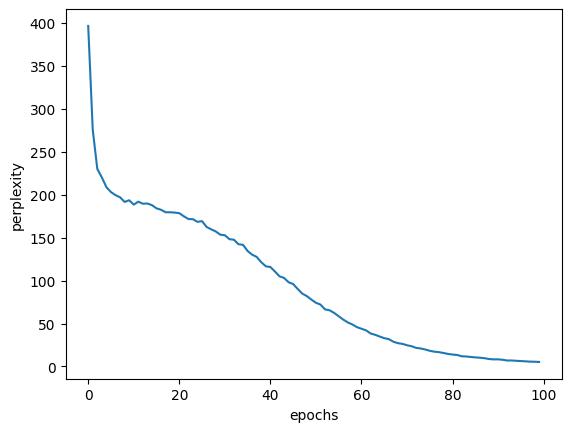

In [17]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb

batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]
ts= corpus[1:]
data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | ppl %.2f' % (epoch + 1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0


# 그래프 그리기
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

| 에폭 1 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 420.55
| 에폭 2 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 386.85
| 에폭 3 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 271.48
| 에폭 4 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 221.75
| 에폭 5 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 210.76
| 에폭 6 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 209.59
| 에폭 7 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.82
| 에폭 8 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 200.13
| 에폭 9 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 195.14
| 에폭 10 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 191.38
| 에폭 11 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.75
| 에폭 12 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 189.89
| 에폭 13 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 192.20
| 에폭 14 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 187.00
| 에폭 15 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 187.17
| 에폭 16 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 190.32
| 에폭 17 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 188.90
| 에폭 18 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 183.51
| 에폭 19 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 180.62
| 에폭 20 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 180.85
| 에폭 21 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 178.32
| 에폭 22 |  반복 1 / 19 | 시간 0[s] | 퍼플렉서티 177.

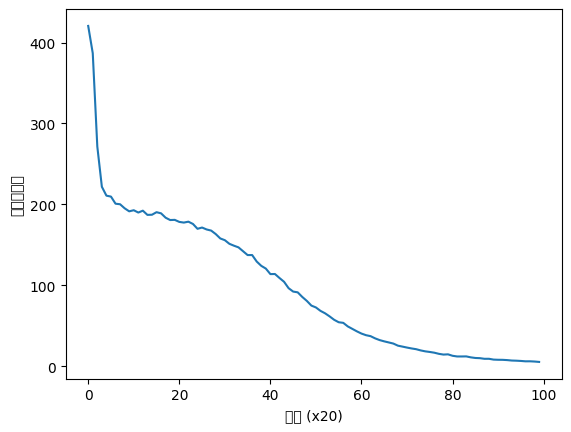

In [18]:
from common.trainer import RnnlmTrainer

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)

trainer.plot()